# Please install the following python libraries
- python3: https://www.python.org/
- numpy: https://numpy.org/install/
- tqdm: https://github.com/tqdm/tqdm#installation
- matplotlib: https://matplotlib.org/stable/users/installing/index.html
- scipy: https://scipy.org/install/
- gym: https://github.com/openai/gym 

If you encounter the error: "IProgress not found. Please update jupyter & ipywidgets"
    
Please install the ipywidgets as follows:

    with pip, do
    - pip install ipywidgets
    
    with conda, do
    - conda install -c conda-forge ipywidgets
    
Restart your notebook 

# Implementation of the Windy GridWorld environment in Example 6.5

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import traceback

In [2]:
"""Windy GridWorld Env"""
class WindyGridWorld(object):
    def __init__(self, enable_king_move=False, enable_no_move=False):
        """
        Args:
            enable_king_move (bool): If True, using King's movement. Otherwise, using the original action space.
            enable_no_move (bool): If True, adding no movement under the condition of enable_king_move = True.
        
        Note: for different setup, we have the following action spaces:
            - Original: ["up", "down", "left", "right"];
            - King's move: ["up", "down", "left", "right", "up-left", "up-right", "down-left", "down-right"];
            - King's move + no move: ["up", "down", "left", "right", "up-left", "up-right", "down-left", "down-right", "stay"]
        """
        
        # define the grid spacen  
        self.grid = np.zeros((7, 10))

        # define the state space
        self.state_space = [[r, c] for r, c in zip(np.where(self.grid == 0.0)[0],
                                                   np.where(self.grid == 0.0)[1])]

        # define the start state
        self.start_state = [3, 0]

        # define the goal state
        self.goal_state = [3, 7]

        # define the wind
        self.wind = np.array([0, 0, 0, 1, 1, 1, 2, 2, 1, 0], dtype=int)

        # define the action space
        if enable_king_move:
            # add King's move actions
            if enable_no_move:
                self.action_space = {
                    "up": np.array([-1, 0]),
                    "down": np.array([1, 0]),
                    "left": np.array([0, -1]),
                    "right": np.array([0, 1]),
                    "up-right": np.array([-1, 1]),  # add up-right
                    "up-left": np.array([-1, -1]),  # add up-left
                    "down-right": np.array([1, 1]),  # add down-right
                    "down-left": np.array([1, -1]),  # add down-left
                    "stay": np.array([0, 0])  # add no move action
                }
            else:
                # add King's move actions + one no movement action
                self.action_space = {
                    "up": np.array([-1, 0]),
                    "down": np.array([1, 0]),
                    "left": np.array([0, -1]),
                    "right": np.array([0, 1]),
                    "up-right": np.array([-1, 1]),  # add up-right
                    "up-left": np.array([-1, -1]),  # add up-left
                    "down-right": np.array([1, 1]),  # add down-right
                    "down-left": np.array([1, -1])  # add down-left
                }
        else:
            # normal actions
            self.action_space = {
                "up": np.array([-1, 0]),
                "down": np.array([1, 0]),
                "left": np.array([0, -1]),
                "right": np.array([0, 1])
            }

        # track the current state, time step, and action
        self.state = None
        self.t = None
        self.act = None

    def reset(self):
        # reset the agent to the start state
        self.state = self.start_state
        # reset the time step tracker
        self.t = 0
        # reset the action tracker
        self.act = None
        # reset the terminal flag
        terminated = False
        return self.state, terminated

    def step(self, act):
        """
        Args:
            act (string): a string variable indicating the action.
        """
        # obtain the state array
        s_arr = np.array(self.state)

        # obtain the action array
        act_arr = self.action_space[act.lower()]

        # obtain the wind array
        wind_arr = -1 * np.array([self.wind[self.state[1]], 0], dtype=int)

        # compute the next state
        next_s_arr = np.clip(s_arr + act_arr + wind_arr,
                             a_min=np.array([0, 0]),
                             a_max=np.array([self.grid.shape[0]-1, self.grid.shape[1]-1]))

        # compute the reward
        reward = 0 if next_s_arr.tolist() == self.goal_state else -1

        # check the termination
        terminated = True if reward == 0 else False

        # update the tracking variables
        self.state = next_s_arr.tolist()
        self.t += 1
        self.act = act

        return self.state, reward, terminated

    def render(self):
        # plot the agent and the goal
        # agent = 1
        # goal = 2
        plot_arr = self.grid.copy()
        plot_arr[self.state[0], self.state[1]] = 1.0
        plot_arr[self.goal_state[0], self.goal_state[1]] = 2.0
        plt.clf()
        fig, arr = plt.subplots(1, 1)
        arr.set_title(f"state={self.state}, act={self.act}")
        arr.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(1)
        plt.close(fig)

In [3]:
"""Plot function similar to Ex1"""
def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly.
        Do not forget to change the ylabel for different plots.
    """
    # set the figure type
    plt.clf()
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # plot results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err = 1.96 * arr_err
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)
    plt.show()

# Test Windy GridWorld 

In [4]:
# check whether enable King's movement and no movement
use_king_move = False
use_no_move = False

# create the environment
env = WindyGridWorld(enable_king_move=use_king_move,
                     enable_no_move=use_no_move)
s, d = env.reset()

# iteracting with the environment for 10 time steps using a random policy
for t in range(10): 
    # sample an random action
    a = np.random.choice(list(env.action_space.keys()), 1)[0]
    
    # interact with the envrionment
    next_s, r, d = env.step(a)
    
    # print info
    print(f"t = {t}: state = {s}, action = {a},  reward = {r}, next_state = {next_s}, done = {d}")
    
    # check termination
    if d:
        s, d = env.reset()

t = 0: state = [3, 0], action = left,  reward = -1, next_state = [3, 0], done = False
t = 1: state = [3, 0], action = left,  reward = -1, next_state = [3, 0], done = False
t = 2: state = [3, 0], action = up,  reward = -1, next_state = [2, 0], done = False
t = 3: state = [3, 0], action = down,  reward = -1, next_state = [3, 0], done = False
t = 4: state = [3, 0], action = up,  reward = -1, next_state = [2, 0], done = False
t = 5: state = [3, 0], action = left,  reward = -1, next_state = [2, 0], done = False
t = 6: state = [3, 0], action = right,  reward = -1, next_state = [2, 1], done = False
t = 7: state = [3, 0], action = down,  reward = -1, next_state = [3, 1], done = False
t = 8: state = [3, 0], action = down,  reward = -1, next_state = [4, 1], done = False
t = 9: state = [3, 0], action = right,  reward = -1, next_state = [4, 2], done = False


# Q4 - (a): Solve the Windy Gridworld using the following algorithms and reproduce the figure similar to the figure in Example 6.5

- Implement the SARSA, Expected SARSA, and Q learning.
- Reproduce the plot in the Example 6.5 and plot the three curves in a single plot. You can use the provided plotting code.

In [5]:
def chooseAction(env, q, state, epsilon):
    action=0
    action_list = list(env.action_space.keys())
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.choice(range(len(action_list)), 1)[0]
    else:
        action_check = np.where(q[tuple(state)] == q[tuple(state)].max())[0]
        action = np.random.choice(action_check, 1)[0]
    return action

In [6]:
""" CODE HERE YOUR IMPLEMENTATION for SARSA """
# SARSA learning
def sARSA(env, num_of_trials, num_of_time_steps, epsilon, action_list, number_of_actions):
  episode_data = np.zeros((num_of_trials, num_of_time_steps))
  q_target = defaultdict(lambda: np.zeros([1,number_of_actions])[0])
  # number_of_actions = len(env.action_space)
  for trail in range(num_of_trials):
    q =  defaultdict(lambda: np.zeros([1,number_of_actions])[0])
    episodes_count = 0
    state1, done = env.reset()
    action1 = chooseAction(env, q, state1, epsilon)
    for step in range(num_of_time_steps):

      action_val = action_list[action1]
      state2, reward, done = env.step(action_val)
      action2 = chooseAction(env, q, state2, epsilon)
      state1 = tuple(state1)
      state2 = tuple(state2)
      q[state1][action1] = q[state1][action1] + alpha * (reward + gamma * q[state2][action2] - q[state1][action1])
      state1 = list(state2)
      action1 = action2

      if done:
        episodes_count += 1
        state1, _ = env.reset()
        action1 = chooseAction(env, q, state1, epsilon)
      episode_data[trail][step] = episodes_count
    q_target = q
  return episode_data, q_target


In [7]:
""" CODE HERE YOUR IMPLEMENTATION for Expected SARSA """
# Expected SARSA learning

def eSARSA(env, num_of_trials, num_of_time_steps, epsilon, action_list, number_of_actions):
  
  episode_data = np.zeros((num_of_trials, num_of_time_steps))
  # number_of_actions = len(env.action_space)
  for trail in range(num_of_trials):
    q =  defaultdict(lambda: np.zeros([1,number_of_actions])[0])
    episodes_count = 0
    state1, done = env.reset()
    
    for step in range(num_of_time_steps):

      action1 = chooseAction(env, q, state1, epsilon)
      action_val = action_list[action1]
      state2, reward, done = env.step(action_val)
     
      state1 = tuple(state1)
      state2 = tuple(state2)

      # calculating for all the actions for q in state2
      q_value = 0
      for i in range(len(env.action_space)):
          q_value =  q_value + epsilon/(number_of_actions) * q[state2][i]
      
      q_value += np.amax(q[state2]) * (1-epsilon)

      q[state1][action1] = q[state1][action1] + alpha * (reward + gamma * q_value - q[state1][action1])
      state1 = list(state2)

      if done:
        episodes_count += 1
        state1, _ = env.reset()
        
      episode_data[trail][step] = episodes_count

  return episode_data


In [8]:
""" CODE HERE YOUR IMPLEMENTATION for Q learning """
# Q learning
def qLearning(env, num_of_trials, num_of_time_steps, epsilon, action_list, number_of_actions):
  
  episode_data = np.zeros((num_of_trials, num_of_time_steps))
  # number_of_actions = len(env.action_space)
  for trail in range(num_of_trials):
    q =  defaultdict(lambda: np.zeros([1,number_of_actions])[0])
    episodes_count = 0
    state1, done = env.reset()
    
    for step in range(num_of_time_steps):

      action1 = chooseAction(env, q, state1, epsilon)
      action_val = action_list[action1]
      state2, reward, done = env.step(action_val)
      action2 = np.argmax(q[tuple(state2)])

      state1 = tuple(state1)
      state2 = tuple(state2)

      q[state1][action1] = q[state1][action1] + alpha * (reward + gamma * q[state2][action2]- q[state1][action1])

      state1 = list(state2)

      if done:
        episodes_count += 1
        state1, _ = env.reset()
        
      episode_data[trail][step] = episodes_count

  return episode_data


In [9]:
# Parameters for the Question 4
num__of_trials = 10
num_of_time_steps = 8000
alpha = 0.5
gamma = 1
epsilon = 0.1

In [10]:
# Windy Gridworld environment
# 4a
env = WindyGridWorld(enable_king_move=False,enable_no_move=False)
state, done = env.reset()
action_list = list(env.action_space.keys())
number_of_actions = len(env.action_space)

s_episodic_data, q_target = sARSA(env, 10, 8000, 0.1, action_list, number_of_actions)
s_episodic_data_es = eSARSA(env, 10, 8000, 0.1, action_list, number_of_actions)
s_episodic_data_q = qLearning(env, 10, 8000, 0.1, action_list, number_of_actions)



<Figure size 432x288 with 0 Axes>

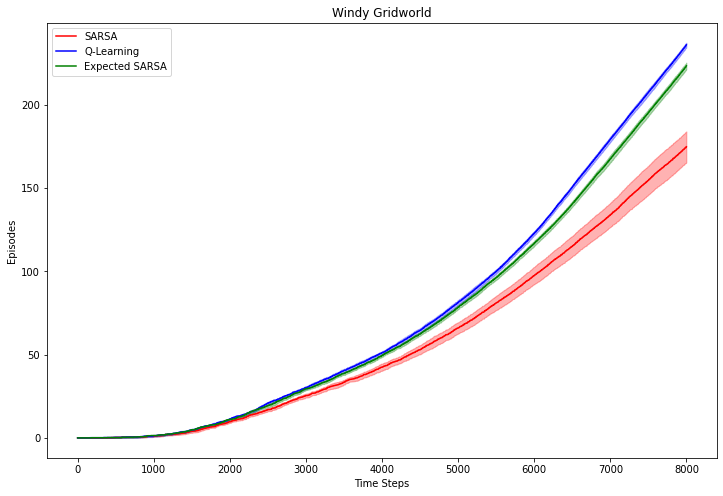

In [11]:
plot_curves([s_episodic_data, s_episodic_data_q, s_episodic_data_es], ['SARSA', "Q-Learning", "Expected SARSA"], ['r', 'b', 'g'], 'Episodes', 'Windy Gridworld')

# Q4 - (b): Re-solve the Windy GridWorld with Kings' movement and No movement.

In [12]:
""" Reproduce the Figure above in Windy GridWorld with King's movement """
# 4b1
# Windy Gridworld environment
# Eight possible actions including diagonals
env = WindyGridWorld(enable_king_move=True,enable_no_move=False)
state, done = env.reset()
action_list = list(env.action_space.keys())
number_of_actions = len(env.action_space)

s_episodic_data, q_target = sARSA(env, 10, 8000, 0.1, action_list, number_of_actions)
s_episodic_data_es = eSARSA(env, 10, 8000, 0.1, action_list, number_of_actions)
s_episodic_data_q = qLearning(env, 10, 8000, 0.1, action_list, number_of_actions)

<Figure size 432x288 with 0 Axes>

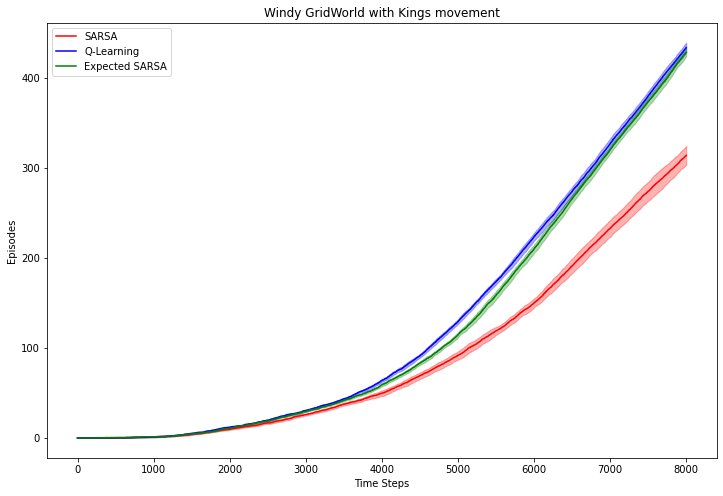

In [13]:
plot_curves([s_episodic_data, s_episodic_data_q, s_episodic_data_es], ['SARSA', "Q-Learning", "Expected SARSA"], ['r', 'b', 'g'], 'Episodes', 'Windy GridWorld with Kings movement')

In [14]:
""" Reproduce the Figure above in Windy GridWorld with King's movement + no movement """
# 4b2
# Windy Gridworld environment
# Eight possible actions including diagonals, Included ninth move to stay
env = WindyGridWorld(enable_king_move=True,enable_no_move=True)
state, done = env.reset()
action_list = list(env.action_space.keys())
number_of_actions = len(env.action_space)

s_episodic_data, q_target = sARSA(env, 10, 8000, 0.1, action_list, number_of_actions)
s_episodic_data_es = eSARSA(env, 10, 8000, 0.1, action_list, number_of_actions)
s_episodic_data_q = qLearning(env, 10, 8000, 0.1, action_list, number_of_actions)

<Figure size 432x288 with 0 Axes>

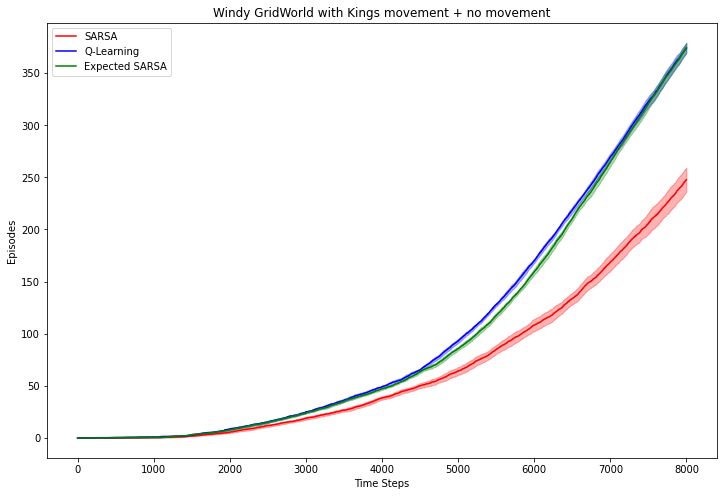

In [15]:
plot_curves([s_episodic_data, s_episodic_data_q, s_episodic_data_es], ['SARSA', "Q-Learning", "Expected SARSA"], ['r', 'b', 'g'], 'Episodes', 'Windy GridWorld with Kings movement + no movement')

# Q5: Bias-variance trade-off

In [16]:
""" Please code your implementation of running the experiments here """


' Please code your implementation of running the experiments here '

In [17]:
""" Please code your implementation of plotting the histogram figure here """

' Please code your implementation of plotting the histogram figure here '

In [18]:
def generating_episodes(env, q_state_action, number_of_episodes):
  """
  parameters
      env: environment
      q_state_action: the state action value matrix for the SARSA
      number_of_episodes: the number of the episodes needed
  return:
    return the list of list of episodes
  """

  episodes_to_return = []
  for it in range(number_of_episodes):
    state, done = env.reset()
    episode_set = []
    while  not done:
      action = chooseAction(env, q_state_action, state, 0.1)
      next_state, reward, done = env.step(action_list[action])
      episode_set.append((state, action, reward))
      state = next_state
    episodes_to_return.append(episode_set)

  return episodes_to_return


In [19]:
def evaluating_monte_carlo(env, episodes_generated, episodes_for_evaluation, gamma):
  stateV = defaultdict(lambda: 0.0)
  countV = defaultdict(lambda: 0)
  hist_data = [0 for i in range(100)]
  vs0 = 0
  counting = 0
  for e_idx, episode in enumerate(episodes_for_evaluation):
    state_list = []
    visited = dict()
    for step in range(len(episode)):
      r = episode[step][2]
      a = episode[step][1]
      s = episode[step][0]
      s = tuple(s)
      if s not in  visited:
        G = 0
        i = step + 1
        while i < len(episode):
          G += episode[i][2]
          i += 1
        countV[s] += 1
        stateV[s] = (stateV[s] * (countV[s] - 1) + G)/countV[s]
        visited[s] = True 
    # vs0.append(stateV[tuple(env.start_state)])
    vs0 = stateV[tuple(env.start_state)]
    counting += 1
      
      # if s not in state_list[0:step]:
      #   s = tuple(s)
      #   countV[s] += 1
      #   stateV[s] += (G-stateV[s])/countV[s]
        
    for idx, episode_t in enumerate(episodes_generated):
      for step in range(len(episode_t)):
        s, a, r = episode_t[step]
      
        G = 0
        i = step+1
        while i <len(episode_t):
          G += gamma * episode_t[i][2]
          i += 1
          if G == vs0/counting:
            hist_data[idx] += G

  return hist_data


In [20]:
def evaluating_monte_carlo(env, episodes_generated, episodes_for_evaluation, gamma):
    stateV = defaultdict(lambda: 0.0)
    returns = defaultdict(lambda: 0)
    countV = defaultdict(lambda: 0)
    hist_data = [0 for i in range(100)]
    vs0 = [] 
    counting = 0
    for e_idx, episode in enumerate(episodes_for_evaluation):
        
        G  = 0
        for step in range(len(episode)-1, -1, -1):
            s, a, r = episode[step]
            s = tuple(s)
            G = gamma  * G + r
            returns[s] += G
            countV[s] += 1
            stateV[s] = (returns[s])/countV[s]
#         vs0.append(stateV[tuple(env.start_state)])
                
# for vs in vs0:   
    for idx, episode_t in enumerate(episodes_generated):
        G_ = 0
        for step in range(len(episode_t)-1, -1, -1):
            s, a, r = episode_t[step] 
            s = tuple(s)
            G_ = gamma * G_ + r
            if s == tuple(env.start_state):
                hist_data[idx] = G_

    return stateV, hist_data


In [21]:
def plotting_histogram(data, title):
  fig, ax = plt.subplots(figsize = (10,7))
  ax.hist(data)
  plt.title(title)

In [22]:
episodes_generated = generating_episodes(env, q_target, 100)

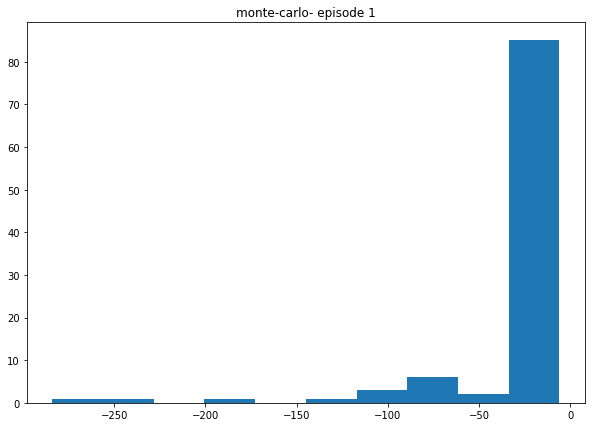

In [23]:
episodes = 1
# env = WindyGridWorld(enable_king_move=False,enable_no_move=False)
episodes_for_evaluation = generating_episodes(env, q_target, episodes)
stateV, hist_data = evaluating_monte_carlo(env, episodes_generated, episodes_for_evaluation, 1)
plotting_histogram(hist_data, "monte-carlo- episode 1")

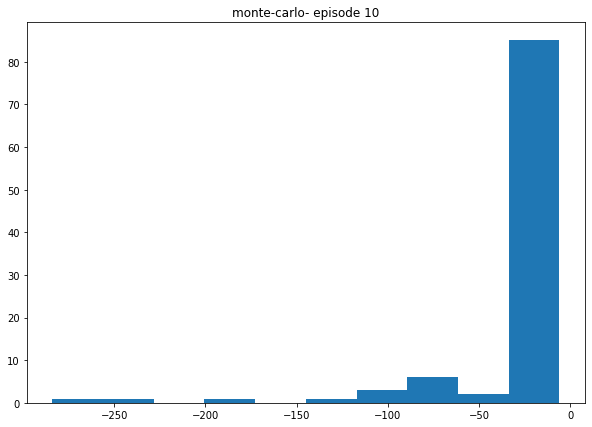

In [24]:
episodes = 10
episodes_for_evaluation = generating_episodes(env, q_target, episodes)
stateV, hist_data = evaluating_monte_carlo(env, episodes_generated, episodes_for_evaluation, 1)
plotting_histogram(hist_data, "monte-carlo- episode 10")


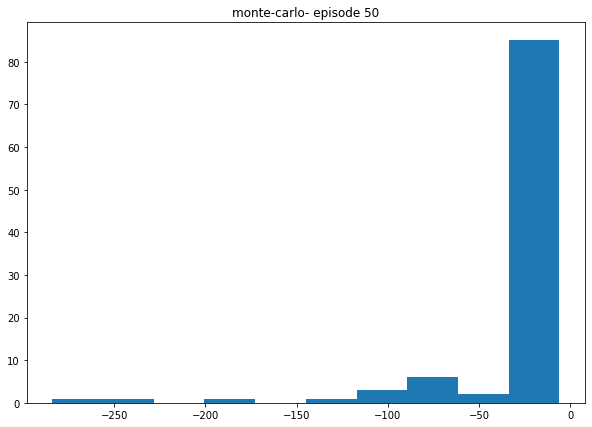

In [25]:
episodes = 50
episodes_for_evaluation = generating_episodes(env, q_target, episodes)
stateV, hist_data = evaluating_monte_carlo(env, episodes_generated, episodes_for_evaluation, 1)
plotting_histogram(hist_data, "monte-carlo- episode 50")

In [26]:
def evaluating_td(env, episodes_generated, episodes_for_evaluation, gamma, alpha):
    stateV = defaultdict(lambda: 0.0)
    stateV[tuple(env.goal_state)] = 0
    returns = defaultdict(lambda: 0)
    countV = defaultdict(lambda: 0)
    hist_data = [0 for i in range(100)]
    vs0 = [] 
    counting = 0
    for e_idx, episode in enumerate(episodes_for_evaluation):
        G  = 0
        for step in range(len(episode)-1):
            s, a, r = episode[step]
            ns = episode[step+1][0]
            s = tuple(s)
            ns = tuple(ns)
            stateV[s] = alpha * (r + gamma * stateV[ns] - stateV[s])

    for idx, episode_t in enumerate(episodes_generated):
        value = 0
        for step in range(len(episode_t)-1):
            s, a, r = episode_t[step] 
            ns = episode_t[step+1][0]
            s = tuple(s)
            ns = tuple(ns)
            value += r + stateV[ns]
            if s == tuple(env.start_state):
                hist_data[idx] = value

    return hist_data

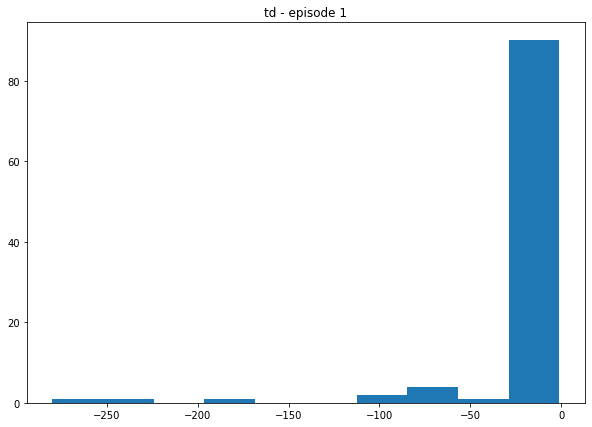

In [27]:
episodes = 1
episodes_for_evaluation = generating_episodes(env, q_target, episodes)
hist_data = evaluating_td(env, episodes_generated, episodes_for_evaluation, 1, 0.5)
plotting_histogram(hist_data,  "td - episode 1")

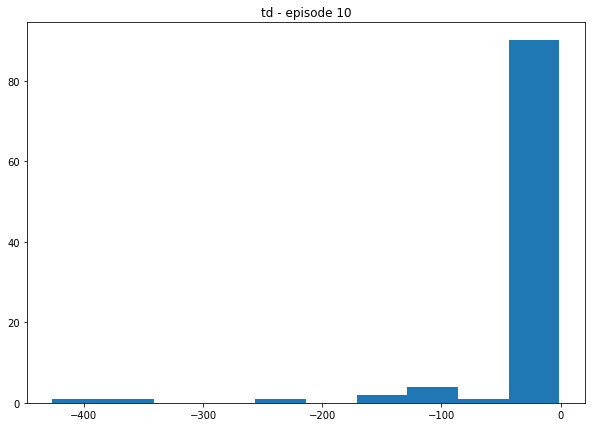

In [28]:
episodes = 10
episodes_for_evaluation = generating_episodes(env, q_target, episodes)
hist_data = evaluating_td(env, episodes_generated, episodes_for_evaluation, 1, 0.5)
plotting_histogram(hist_data, "td - episode 10")

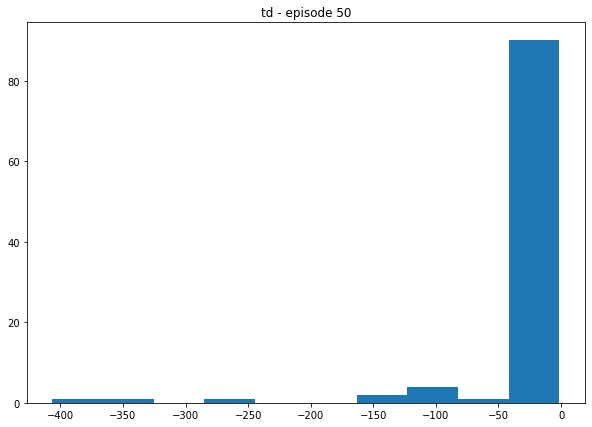

In [29]:
episodes = 50
episodes_for_evaluation = generating_episodes(env, q_target, episodes)
hist_data = evaluating_td(env, episodes_generated, episodes_for_evaluation, 1, 0.5)
plotting_histogram(hist_data, "td - episode 50")